Processing dataset: Dataset7

Calculated NCC Statistics:
           Calculated NCC
count        7140.000000
mean            0.432636
std             0.134788
min             0.081492
25%             0.405897
50%             0.487471
75%             0.518266
max             0.999950
skew           -1.330347
kurtosis        0.682971

New NCC Statistics:
               New NCC
count     7140.000000
mean         0.624592
std          0.242410
min          0.078706
25%          0.683855
50%          0.735455
75%          0.762474
max          0.804553
skew        -1.548463
kurtosis     0.585376


/var/folders/ty/5ms_sgfx2gzgt3kljnjcpcn40000gn/T/ipykernel_1029/1246588553.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Calculated NCC', 'New NCC'])


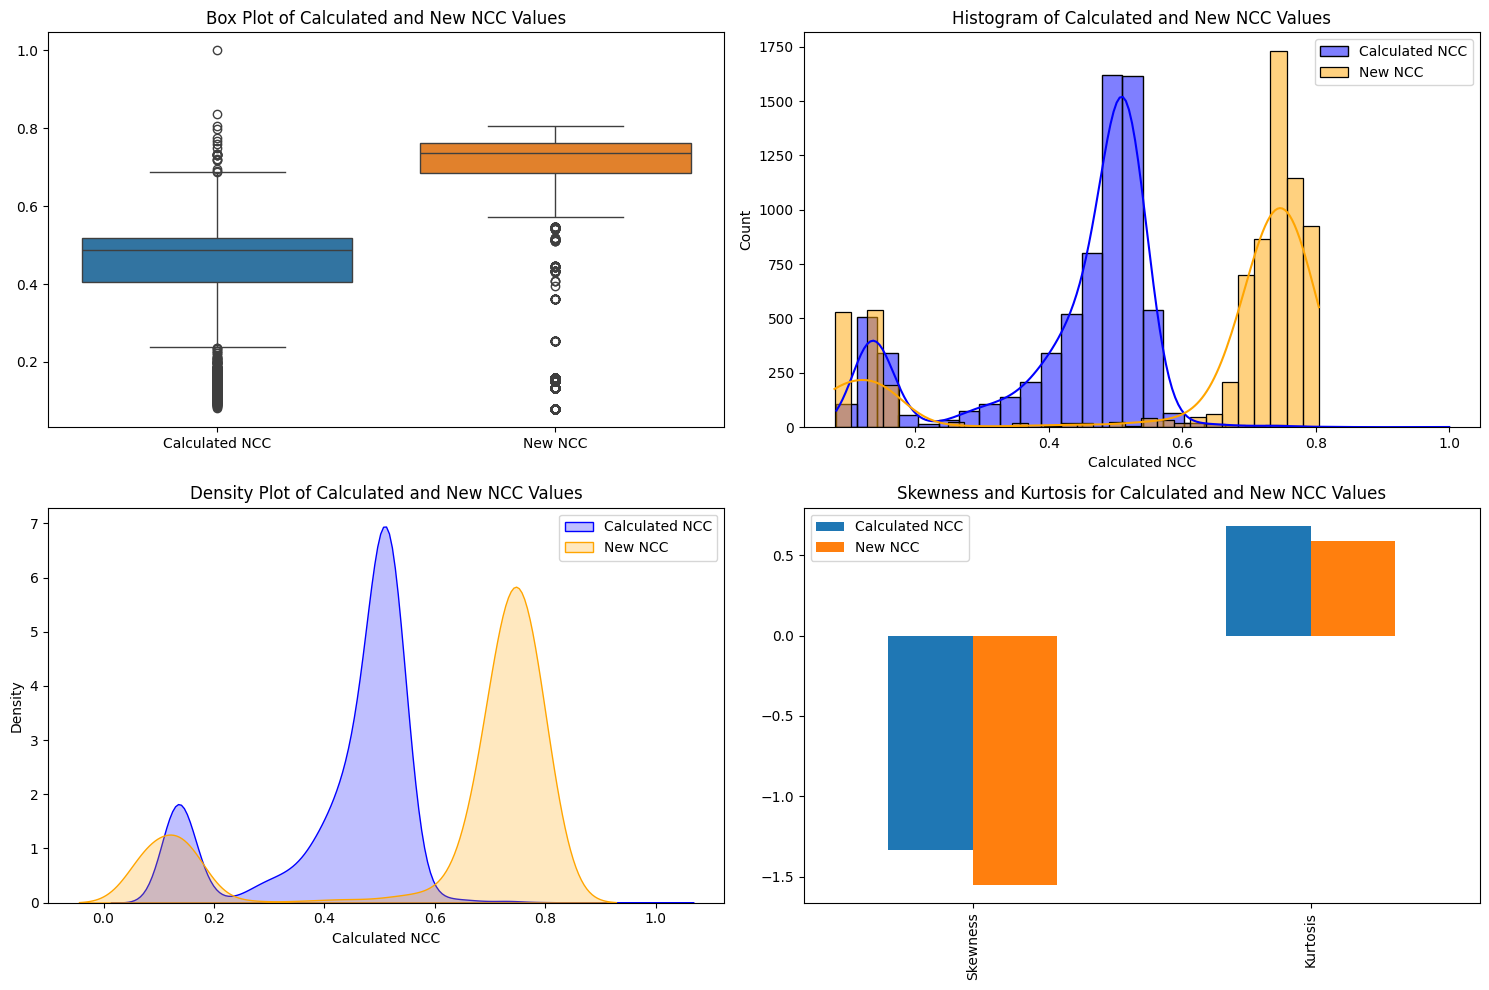

NCC values saved as 'Dataset7_ncc_values_calculated.csv' and 'Dataset7_ncc_values_new.csv'.



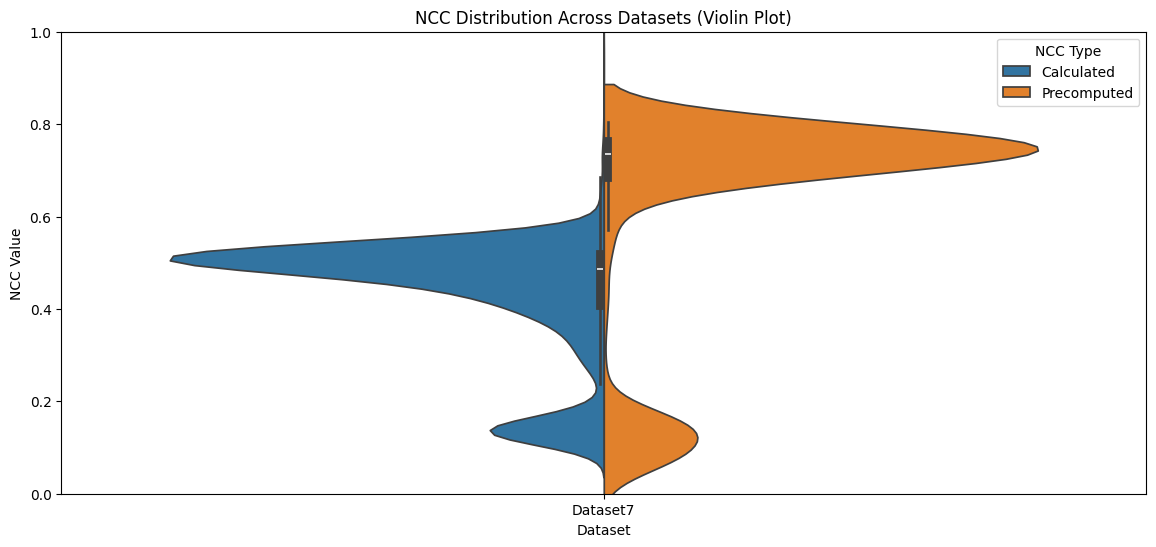

/var/folders/ty/5ms_sgfx2gzgt3kljnjcpcn40000gn/T/ipykernel_1029/1246588553.py:293: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="NCC Type")


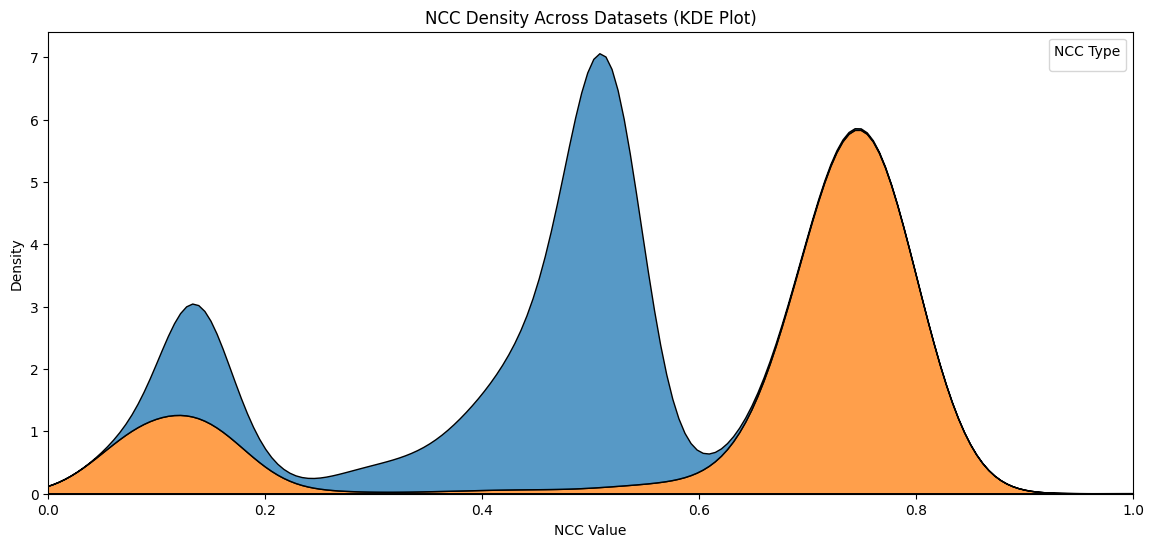

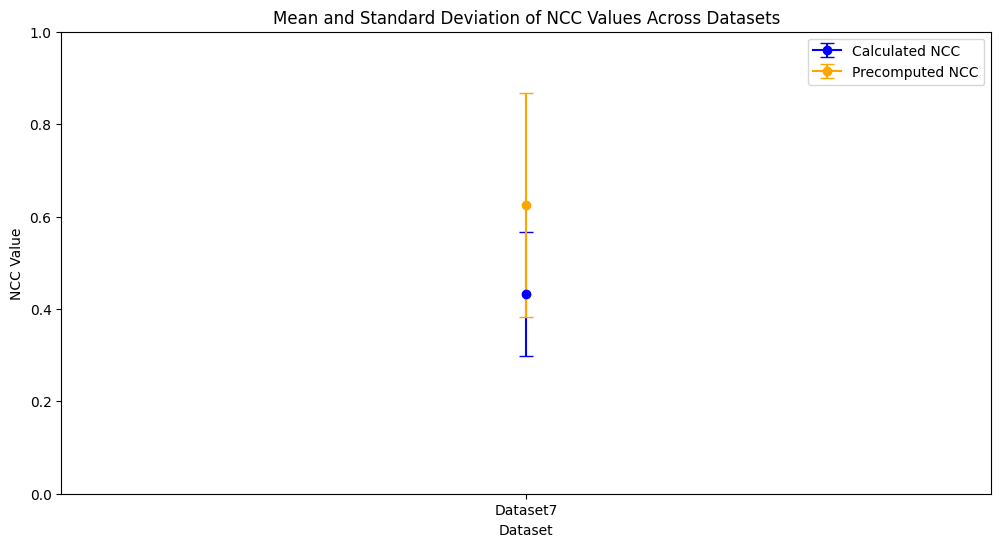

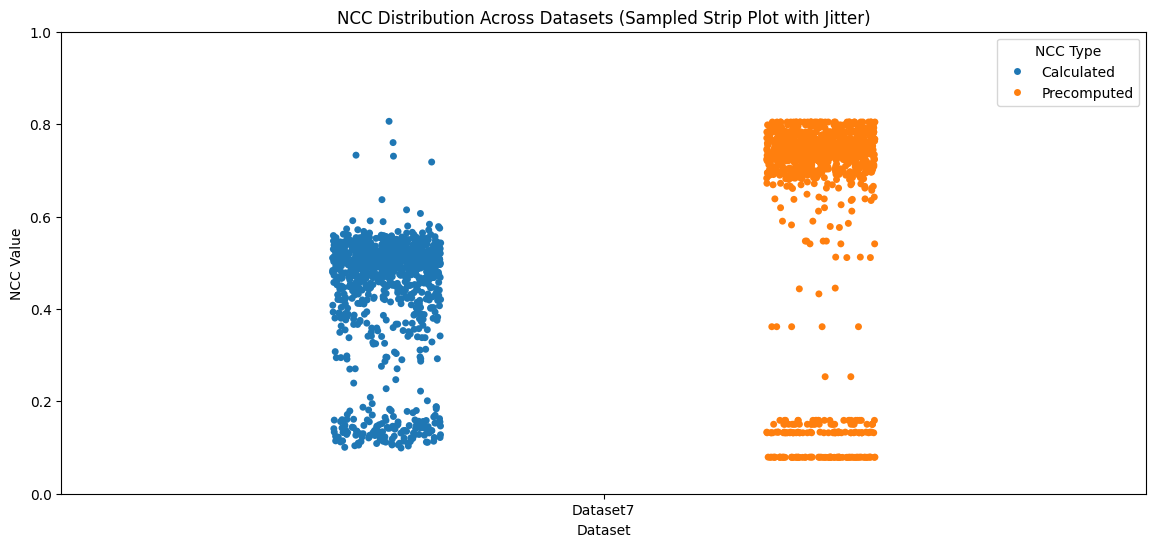

In [ ]:
# Jupyter Notebook

# Import necessary libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from scipy.stats import zscore

# Data loading function
def load_ebsd_data(file_path):
    with h5py.File(file_path, 'r') as file:
        ebsd_data = np.array(file['/1/EBSD/Data/Processed Patterns'])
        X_coords, Y_coords = file['/1/EBSD/Data/X'][:], file['/1/EBSD/Data/Y'][:]
    return ebsd_data, X_coords, Y_coords

# Data cleaning function to handle missing values and outliers
def clean_data(data):
    nan_mask = np.isnan(data)
    if np.any(nan_mask):
        data = np.where(nan_mask, np.nanmean(data, axis=0), data)
    z_scores = zscore(data, axis=None)
    abs_z_scores = np.abs(z_scores)
    data = np.where(abs_z_scores < 3, data, np.nanmean(data))
    return data

# Function to extract first quadrant
def extract_first_quadrant(data, X_coords, Y_coords):
    mid_x, mid_y = X_coords.max() // 2, Y_coords.max() // 2
    quadrant_1_indices = (X_coords < mid_x) & (Y_coords < mid_y)
    return data[quadrant_1_indices], X_coords[quadrant_1_indices], Y_coords[quadrant_1_indices]

# Function to perform K-means clustering
def perform_clustering(data, n_clusters=178):
    flattened_data = data.reshape(data.shape[0], -1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flattened_data)
    return kmeans, kmeans.labels_, flattened_data

# Function for normalization and NCC calculation
def norm_data(data):
    return (data - np.mean(data)) / np.std(data, ddof=1)

def ncc(data0, data1):
    return np.mean(norm_data(data0) * norm_data(data1))

# Function to calculate NCC values for each cluster
def calculate_ncc_values(labels, flattened_data, kmeans):
    ncc_values = np.zeros(len(labels))
    for cluster_idx in range(kmeans.n_clusters):
        cluster_indices = np.where(labels == cluster_idx)[0]
        centroid_pattern = kmeans.cluster_centers_[cluster_idx]
        ncc_values_cluster = [ncc(centroid_pattern, flattened_data[idx]) for idx in cluster_indices]
        ncc_values[cluster_indices] = ncc_values_cluster
    return ncc_values

# Function to load precomputed NCC values
def load_precomputed_ncc(file_path, X_coords, Y_coords):
    with h5py.File(file_path, 'r') as file:
        new_ncc_values = file['/1/Data Processing/Pattern Matching/Data/Cross Correlation Coefficient'][:]
        X_coords_new, Y_coords_new = file['/1/EBSD/Data/X'][:], file['/1/EBSD/Data/Y'][:]
    first_quadrant_indices_new = (X_coords_new < X_coords_new.max() // 2) & (Y_coords_new < Y_coords_new.max() // 2)
    return new_ncc_values[first_quadrant_indices_new]

# Function to ensure NCC values are within the 0 to 1 range
def clean_ncc_values(ncc_values):
    return np.clip(ncc_values, 0, 1)

# Function to calculate and display statistics
def calculate_statistics(df):
    stats = df.describe()
    stats.loc['skew'] = df.skew()
    stats.loc['kurtosis'] = df.kurtosis()
    return stats

# Function to generate statistical plots
def plot_statistics(calculated_df, new_df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    sns.boxplot(data=[calculated_df.iloc[:, 0], new_df.iloc[:, 0]], ax=axes[0, 0])
    axes[0, 0].set_xticklabels(['Calculated NCC', 'New NCC'])
    axes[0, 0].set_title("Box Plot of Calculated and New NCC Values")
    sns.histplot(calculated_df.iloc[:, 0], bins=30, color='blue', kde=True, ax=axes[0, 1], label="Calculated NCC")
    sns.histplot(new_df.iloc[:, 0], bins=30, color='orange', kde=True, ax=axes[0, 1], label="New NCC")
    axes[0, 1].set_title("Histogram of Calculated and New NCC Values")
    axes[0, 1].legend()
    sns.kdeplot(calculated_df.iloc[:, 0], color='blue', fill=True, ax=axes[1, 0], label="Calculated NCC")
    sns.kdeplot(new_df.iloc[:, 0], color='orange', fill=True, ax=axes[1, 0], label="New NCC")
    axes[1, 0].set_title("Density Plot of Calculated and New NCC Values")
    axes[1, 0].legend()
    stats = pd.DataFrame({
        "Calculated NCC": [calculated_df.iloc[:, 0].skew(), calculated_df.iloc[:, 0].kurtosis()],
        "New NCC": [new_df.iloc[:, 0].skew(), new_df.iloc[:, 0].kurtosis()]
    }, index=["Skewness", "Kurtosis"])
    stats.plot(kind="bar", ax=axes[1, 1])
    axes[1, 1].set_title("Skewness and Kurtosis for Calculated and New NCC Values")
    plt.tight_layout()
    plt.show()

# Main function to process multiple datasets
def process_datasets(datasets):
    results = {}
    for name, paths in datasets.items():
        ebsd_path, ncc_path = paths
        print(f"Processing dataset: {name}")

        # Load and clean data
        ebsd_data, X_coords, Y_coords = load_ebsd_data(ebsd_path)
        ebsd_data_cleaned = clean_data(ebsd_data)
        quadrant_1_data, X_coords_1, Y_coords_1 = extract_first_quadrant(ebsd_data_cleaned, X_coords, Y_coords)

        # Perform clustering and calculate NCC
        kmeans, labels, flattened_images_1 = perform_clustering(quadrant_1_data)
        ncc_values_calculated = calculate_ncc_values(labels, flattened_images_1, kmeans)

        # Load precomputed NCC values
        ncc_values_new = load_precomputed_ncc(ncc_path, X_coords, Y_coords)

        # Clean NCC values and save as DataFrames
        ncc_values_calculated = clean_ncc_values(ncc_values_calculated)
        ncc_values_new = clean_ncc_values(ncc_values_new)
        calculated_df = pd.DataFrame(ncc_values_calculated, columns=['Calculated NCC'])
        new_df = pd.DataFrame(ncc_values_new, columns=['New NCC'])

        # Calculate statistics
        calculated_stats = calculate_statistics(calculated_df)
        new_stats = calculate_statistics(new_df)
        print("\nCalculated NCC Statistics:\n", calculated_stats)
        print("\nNew NCC Statistics:\n", new_stats)

        # Generate plots
        plot_statistics(calculated_df, new_df)

        # Store results in a dictionary for each dataset
        results[name] = {
            'calculated_df': calculated_df,
            'new_df': new_df,
            'calculated_stats': calculated_stats,
            'new_stats': new_stats
        }
        
        # Save the NCC values as CSV files
        calculated_df.to_csv(f'{name}_ncc_values_calculated.csv', index=False)
        new_df.to_csv(f'{name}_ncc_values_new.csv', index=False)
        print(f"NCC values saved as '{name}_ncc_values_calculated.csv' and '{name}_ncc_values_new.csv'.\n")

    return results

    # Function to plot NCC distribution across multiple datasets using box plots
# Function to plot NCC distribution across multiple datasets using box plots
def plot_ncc_distributions(results):
    """
    Plots the distribution of NCC values for each dataset in the results dictionary.

    Parameters:
    - results (dict): Dictionary containing calculated and precomputed NCC DataFrames for each dataset.
    """
    # Lists to hold data for plotting
    dataset_names = []
    ncc_values = []
    ncc_types = []

    # Collect NCC values and dataset names for plotting
    for dataset_name, data in results.items():
        # Append calculated NCC values
        dataset_names.extend([dataset_name] * len(data['calculated_df']))
        ncc_values.extend(data['calculated_df']['Calculated NCC'])
        ncc_types.extend(['Calculated'] * len(data['calculated_df']))

        # Append precomputed (new) NCC values
        dataset_names.extend([dataset_name] * len(data['new_df']))
        ncc_values.extend(data['new_df']['New NCC'])
        ncc_types.extend(['Precomputed'] * len(data['new_df']))

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Dataset': dataset_names,
        'NCC Value': ncc_values,
        'Type': ncc_types
    })

    # Plot NCC distributions using box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Dataset', y='NCC Value', hue='Type', data=plot_data)
    plt.title("NCC Distribution Across Datasets (Calculated vs Precomputed)")
    plt.xlabel("Dataset")
    plt.ylabel("NCC Value")
    plt.ylim(0, 1)  # since NCC should be within [0, 1]
    plt.legend(title="NCC Type")
    plt.show()


# Function to plot mean and standard deviation of NCC values for each dataset
def plot_ncc_mean_std(results):
    """
    Plots the mean and standard deviation of NCC values across datasets.

    Parameters:
    - results (dict): Dictionary containing calculated and precomputed NCC DataFrames for each dataset.
    """
    dataset_names = []
    calculated_means = []
    calculated_stds = []
    new_means = []
    new_stds = []

    # Collect mean and standard deviation data for each dataset
    for dataset_name, data in results.items():
        dataset_names.append(dataset_name)
        calculated_means.append(data['calculated_df']['Calculated NCC'].mean())
        calculated_stds.append(data['calculated_df']['Calculated NCC'].std())
        new_means.append(data['new_df']['New NCC'].mean())
        new_stds.append(data['new_df']['New NCC'].std())

    # Create a DataFrame for plotting
    mean_std_data = pd.DataFrame({
        'Dataset': dataset_names,
        'Calculated Mean': calculated_means,
        'Calculated Std': calculated_stds,
        'New Mean': new_means,
        'New Std': new_stds
    })

    # Plot mean and standard deviation using line plots with error bars
    plt.figure(figsize=(12, 6))
    plt.errorbar(mean_std_data['Dataset'], mean_std_data['Calculated Mean'], yerr=mean_std_data['Calculated Std'], 
                 fmt='-o', capsize=5, label='Calculated NCC', color='blue')
    plt.errorbar(mean_std_data['Dataset'], mean_std_data['New Mean'], yerr=mean_std_data['New Std'], 
                 fmt='-o', capsize=5, label='Precomputed NCC', color='orange')
    plt.title("Mean and Standard Deviation of NCC Values Across Datasets")
    plt.xlabel("Dataset")
    plt.ylabel("NCC Value")
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

def plot_ncc_violin(results):
    # Prepare data for plotting
    dataset_names, ncc_values, ncc_types = [], [], []
    
    for dataset_name, data in results.items():
        dataset_names.extend([dataset_name] * len(data['calculated_df']))
        ncc_values.extend(data['calculated_df']['Calculated NCC'])
        ncc_types.extend(['Calculated'] * len(data['calculated_df']))
        
        dataset_names.extend([dataset_name] * len(data['new_df']))
        ncc_values.extend(data['new_df']['New NCC'])
        ncc_types.extend(['Precomputed'] * len(data['new_df']))
    
    plot_data = pd.DataFrame({
        'Dataset': dataset_names,
        'NCC Value': ncc_values,
        'Type': ncc_types
    })
    
    # Violin Plot
    plt.figure(figsize=(14, 6))
    sns.violinplot(x='Dataset', y='NCC Value', hue='Type', data=plot_data, split=True)
    plt.title("NCC Distribution Across Datasets (Violin Plot)")
    plt.xlabel("Dataset")
    plt.ylabel("NCC Value")
    plt.ylim(0, 1)
    plt.legend(title="NCC Type")
    plt.show()

def plot_ncc_kde(results):
    # Prepare data for plotting (similar structure as violin plot)
    dataset_names, ncc_values, ncc_types = [], [], []
    
    for dataset_name, data in results.items():
        dataset_names.extend([dataset_name] * len(data['calculated_df']))
        ncc_values.extend(data['calculated_df']['Calculated NCC'])
        ncc_types.extend(['Calculated'] * len(data['calculated_df']))
        
        dataset_names.extend([dataset_name] * len(data['new_df']))
        ncc_values.extend(data['new_df']['New NCC'])
        ncc_types.extend(['Precomputed'] * len(data['new_df']))
    
    plot_data = pd.DataFrame({
        'Dataset': dataset_names,
        'NCC Value': ncc_values,
        'Type': ncc_types
    })
    
    # KDE Plot
    plt.figure(figsize=(14, 6))
    sns.kdeplot(data=plot_data, x="NCC Value", hue="Type", multiple="stack", common_norm=False)
    plt.title("NCC Density Across Datasets (KDE Plot)")
    plt.xlabel("NCC Value")
    plt.ylabel("Density")
    plt.xlim(0, 1)
    plt.legend(title="NCC Type")
    plt.show()

def plot_ncc_mean_std_line(results):
    dataset_names, calculated_means, calculated_stds, new_means, new_stds = [], [], [], [], []

    for dataset_name, data in results.items():
        dataset_names.append(dataset_name)
        calculated_means.append(data['calculated_df']['Calculated NCC'].mean())
        calculated_stds.append(data['calculated_df']['Calculated NCC'].std())
        new_means.append(data['new_df']['New NCC'].mean())
        new_stds.append(data['new_df']['New NCC'].std())

    mean_std_data = pd.DataFrame({
        'Dataset': dataset_names,
        'Calculated Mean': calculated_means,
        'Calculated Std': calculated_stds,
        'New Mean': new_means,
        'New Std': new_stds
    })

    plt.figure(figsize=(12, 6))
    plt.errorbar(mean_std_data['Dataset'], mean_std_data['Calculated Mean'], yerr=mean_std_data['Calculated Std'], 
                 fmt='-o', capsize=5, label='Calculated NCC', color='blue')
    plt.errorbar(mean_std_data['Dataset'], mean_std_data['New Mean'], yerr=mean_std_data['New Std'], 
                 fmt='-o', capsize=5, label='Precomputed NCC', color='orange')
    plt.title("Mean and Standard Deviation of NCC Values Across Datasets")
    plt.xlabel("Dataset")
    plt.ylabel("NCC Value")
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

def plot_ncc_strip_sample(results, sample_size=1000):
    """
    Plots a sample of NCC values for each dataset using a strip plot with jitter.

    Parameters:
    - results (dict): Dictionary containing calculated and precomputed NCC DataFrames for each dataset.
    - sample_size (int): Number of points to sample for each dataset to reduce plot clutter.
    """
    dataset_names, ncc_values, ncc_types = [], [], []
    
    for dataset_name, data in results.items():
        # Sample calculated NCC values
        calculated_sample = data['calculated_df']['Calculated NCC'].sample(n=sample_size, random_state=0) if len(data['calculated_df']) > sample_size else data['calculated_df']['Calculated NCC']
        dataset_names.extend([dataset_name] * len(calculated_sample))
        ncc_values.extend(calculated_sample)
        ncc_types.extend(['Calculated'] * len(calculated_sample))
        
        # Sample new NCC values
        new_sample = data['new_df']['New NCC'].sample(n=sample_size, random_state=0) if len(data['new_df']) > sample_size else data['new_df']['New NCC']
        dataset_names.extend([dataset_name] * len(new_sample))
        ncc_values.extend(new_sample)
        ncc_types.extend(['Precomputed'] * len(new_sample))
    
    plot_data = pd.DataFrame({
        'Dataset': dataset_names,
        'NCC Value': ncc_values,
        'Type': ncc_types
    })
    
    # Strip Plot with Jitter
    plt.figure(figsize=(14, 6))
    sns.stripplot(x='Dataset', y='NCC Value', hue='Type', data=plot_data, jitter=True, dodge=True)
    plt.title("NCC Distribution Across Datasets (Sampled Strip Plot with Jitter)")
    plt.xlabel("Dataset")
    plt.ylabel("NCC Value")
    plt.ylim(0, 1)
    plt.legend(title="NCC Type")
    plt.show()


# Example usage
# Assuming `results` is the dictionary from the previous function `process_datasets`


# Example usage with multiple datasets
datasets = {
    # 'Dataset1': ('/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 1 frame.h5oina','/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 1 frame_1quadrantprocessed.h5oina'),
    # 'Dataset2': ('/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 4 frames.h5oina','/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 4 frames_1quadrantprocessed.h5oina'),
    # 'Dataset3': ('/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 9 frames.h5oina','/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 9 frames_1quadrantprocessed.h5oina'),
    # 'Dataset4': ('/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 16 frames.h5oina','/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 16 frames_1quadrantprocessed.h5oina'),
    # 'Dataset5': ('/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 25 frames.h5oina','/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 25 frames_1quadrantprocessed.h5oina'),
    # 'Dataset6': ('/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test saturated 49 pps(1).h5oina','/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test saturated 49 pps(1).h5oina'),
    # 'Dataset7': ('/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed x16.h5oina','/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x16.h5oina'),
    # 'Dataset8': ('/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed x32(1).h5oina','/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x32(1).h5oina'),
    # 'Dataset9': ('/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed x64.h5oina','/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x64.h5oina')
}

results = process_datasets(datasets)
plot_ncc_violin(results)
plot_ncc_kde(results)
plot_ncc_mean_std_line(results)
plot_ncc_strip_sample(results, sample_size=1000)


